# 1. Tratamento de dados do CMIP6

```shell
Esse caderno tem como objetivo a obtenção de precipitações acumuladas 
mensais para dados do CMIP6.
```

- Informações para bases de dados da Paraíba:

    ```shell
    Extremo Norte: -6.0°        S
    Extremo Sul  : -8.5°        S
    Extremo Leste: 360° - 33.5° W
    Extremo Oeste: 360° - 39.0° W

    Dados Históricos: 1994-2014
    Dados Preditivos: 2015-2100
    ```

In [1]:
import os
import pandas as pd
import xarray as xr
import contextily as ctx
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature

from matplotlib.ticker import MaxNLocator

## 1.2. Funções

### 1.2.1. Função para visualização de colunas em NC

In [2]:
def colunas_ds(caminho: str, engine: str = 'h5netcdf'):
    '''
    Possibilita a visualização de colunas presentes em um arquivo .nc
    '''
    
    # Abrir o dataset
    ds = xr.open_dataset(caminho, engine=engine)

    # Mostrar as variáveis de dados (as "colunas" com valores reais)
    print(ds.data_vars)

    ds.close()

### 1.2.2. Função para recorte de dados em NC e transformação em DataFrame

In [3]:
def recorte_de_dados(caminho: str, 
                     lat_max: float, 
                     lat_min: float, 
                     lon_max: float, 
                     lon_min: float, 
                     variavel: str = 'pr',
                     engine: str = 'h5netcdf') -> pd.DataFrame:
    '''
    Recorta dados de um arquivo NC com base nas suas localizações, e transforma em DataFrame pandas
    '''

    # Abrir o arquivo
    ds = xr.open_dataset(caminho, engine=engine)

    # Filtrar o dado da variável para o intervalo
    pr_filtrado = ds[variavel].sel(
        lat=slice(lat_min, lat_max),
        lon=slice(lon_min, lon_max)
    )

    # (Opcional) Transformar em DataFrame e salvar como CSV
    df = pr_filtrado.to_dataframe().reset_index()

    return df

### 1.2.3. Função para gerar precipitação mensal acumulada ou máxima

In [4]:
def tipo_de_pr(df: pd.DataFrame, tipo: str = 'sum') -> pd.DataFrame:
    '''
    A partir de um DataFrame pandas com precipitações diárias, converte a frequência para mensal acumulada ou máxima.
    '''

    # Precipitação acumulada
    if tipo == 'sum':
        df_mensal = df.groupby(['ano', 'mes', 'lat', 'lon'], as_index=False)['pr'].sum()

    # Precipitação acumulada
    elif tipo == 'max':
        df_mensal = df.groupby(['ano', 'mes', 'lat', 'lon'], as_index=False)['pr'].max()

    return df_mensal

### 1.2.4. Função para gerar gráfico de pontos para Paraíba

In [ ]:
def grafico_de_pontos(df: pd.DataFrame,
                      latitude: str,
                      longitude: str):
    '''
    Função gera gráfico de pontos para região da Paraíba a partir de DataFrame
    '''
    
    # Exemplo de dados de precipitação
    latitudes = df[latitude].values
    longitudes = df[longitude].values

    # Criar o gráfico com Cartopy
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.Mercator()})
    ax.set_extent([-38.8, -34.7, -8.3, -6], crs=ccrs.PlateCarree())  # Definir a extensão de latitude e longitude

    # Adicionar o mapa base
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    # Desenhar as bordas do mapa
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.5)
    ax.add_feature(cfeature.STATES, linestyle='-', linewidth=0.5)

    # Desenhar paralelos e meridianos, ajustando a frequência dos labels
    gridlines = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
    gridlines.xlocator = MaxNLocator(integer=True, prune='lower', nbins=4)  # Limitar o número de labels para longitude
    gridlines.ylocator = MaxNLocator(integer=True, prune='lower', nbins=4)  # Limitar o número de labels para latitude

    # Criar o scatter plot com pontos azuis
    ax.scatter(longitudes, latitudes, color='blue', s=3, marker='o', transform=ccrs.PlateCarree())

    # Adicionar título e rótulos
    plt.title('Estado da Paraíba')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Mostrar o mapa
    plt.show()

## 1.3. CNRM-CM6-1-HR

### 1.3.1. Conversão de bases de dados em CSV

In [ ]:
# Caminho dos modelos NC
caminho_nc = '../datas/raw/1_cmip6_data/'

# Caminho dos modelos CSV
caminho_csv = '../datas/interim/1.3.1_nc_to_csv/'

colunas_ds(caminho_nc + 'pr_day_CNRM-CM6-1-HR_historical_r1i1p1f2_gr_19940101-20141231.nc')

Data variables:
    time_bounds  (time, axis_nbounds) datetime64[ns] 123kB ...
    pr           (time, lat, lon) float32 3MB ...


In [7]:
# Lista de modelos
modelos = os.listdir(caminho_nc)

# Varrendo modelos
for modelo in modelos:

    # Definindo base de dados
    df = recorte_de_dados(caminho_nc + modelo, -6, -8.5, 325.5, 321)

    # Salvar o DataFrame combinado em um arquivo CSV
    if os.path.exists(caminho_csv + modelo.split('.')[0] + '.csv') == False:
        df.to_csv(caminho_csv + modelo.split('.')[0] + '.csv')

### 1.3.2. Criação de base de dados com precipitação acumulada

In [8]:
df_CNRM_CM6_1_HR_1994_2014 = pd.read_csv(caminho_csv + 'pr_day_CNRM-CM6-1-HR_historical_r1i1p1f2_gr_19940101-20141231.csv')
df_CNRM_CM6_1_HR_2015_2039 = pd.read_csv(caminho_csv + 'pr_day_CNRM-CM6-1-HR_ssp585_r1i1p1f2_gr_20150101-20391231.csv')
df_CNRM_CM6_1_HR_2040_2064 = pd.read_csv(caminho_csv + 'pr_day_CNRM-CM6-1-HR_ssp585_r1i1p1f2_gr_20400101-20641231.csv')
df_CNRM_CM6_1_HR_2065_2089 = pd.read_csv(caminho_csv + 'pr_day_CNRM-CM6-1-HR_ssp585_r1i1p1f2_gr_20650101-20891231.csv')
df_CNRM_CM6_1_HR_2090_2100 = pd.read_csv(caminho_csv + 'pr_day_CNRM-CM6-1-HR_ssp585_r1i1p1f2_gr_20900101-21001231.csv')

# Lista com todos os DataFrames
df_CNRM_CM6_1_HR = [
    df_CNRM_CM6_1_HR_1994_2014,
    df_CNRM_CM6_1_HR_2015_2039,
    df_CNRM_CM6_1_HR_2040_2064,
    df_CNRM_CM6_1_HR_2065_2089,
    df_CNRM_CM6_1_HR_2090_2100
]

# Concatenar tudo em um único DataFrame
df_CNRM_CM6_1_HR = pd.concat(df_CNRM_CM6_1_HR, ignore_index=True)

# Garantir que a coluna 'time' está no formato datetime
df_CNRM_CM6_1_HR['time'] = pd.to_datetime(df_CNRM_CM6_1_HR['time'])

# Criar colunas para ano, mês e dia
df_CNRM_CM6_1_HR['ano'] = df_CNRM_CM6_1_HR['time'].dt.year
df_CNRM_CM6_1_HR['mes'] = df_CNRM_CM6_1_HR['time'].dt.month
df_CNRM_CM6_1_HR['dia'] = df_CNRM_CM6_1_HR['time'].dt.day

# Remover colunas indesejadas
df_CNRM_CM6_1_HR = df_CNRM_CM6_1_HR.drop(columns=['time', 'dia'])

In [ ]:
# Definindo base de dados com pr acumulado
df_CNRM_CM6_1_HR_sum = tipo_de_pr(df_CNRM_CM6_1_HR, 'sum')

# Caminho para salvar base de dados com pr acumulado
caminho_sum = '../datas/interim/1.3.2_cmip6_database_create/pr_day_CNRM-CM6-1-HR_ssp585_r1i1p1f2_gr_19940101-21001231_sum.csv'

# Salvar o DataFrame combinado em um arquivo CSV
if os.path.exists(caminho_sum) == False:
    df_CNRM_CM6_1_HR_sum.to_csv(caminho_sum)

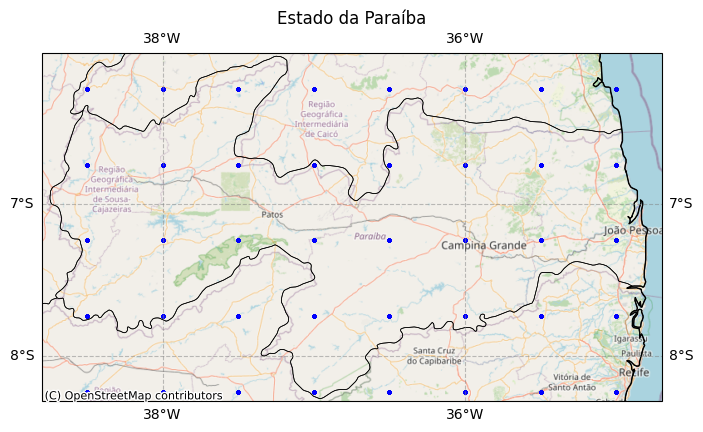

In [ ]:
# Definição de base de dados original
df_CNRM_CM6_1_HR_sum = pd.read_csv(caminho_sum)

grafico_de_pontos(df_CNRM_CM6_1_HR_sum, 'lat', 'lon')